# Giesekus SAOS: Linear Viscoelasticity and Relaxation Spectrum

## Learning Objectives

1. Fit the Giesekus model to real polystyrene SAOS data (G', G'')
2. Understand that SAOS is **α-independent** in the linear regime
3. Extract relaxation time λ from crossover frequency ω_c = 1/λ
4. Compare single-mode vs multi-mode fitting for broad spectra
5. Use Cole-Cole representation for relaxation spectrum visualization

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)
- NB 01: Giesekus flow curve (recommended)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode, GiesekusMultiMode

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Giesekus SAOS Response

### Small-Amplitude Oscillatory Shear

In SAOS, we apply a sinusoidal strain:
$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

For small amplitudes (γ₀ << 1), the stress response is also sinusoidal:
$$
\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]
$$

where:
- $G'(\omega)$ = storage modulus (elastic response)
- $G''(\omega)$ = loss modulus (viscous response)

### Giesekus Linear Response

**Key insight:** In the linear regime, Giesekus reduces to Maxwell!

The quadratic τ·τ term vanishes for small stresses, giving:
$$
G'(\omega) = G_0 \frac{(\omega\lambda)^2}{1 + (\omega\lambda)^2}
$$
$$
G''(\omega) = G_0 \frac{\omega\lambda}{1 + (\omega\lambda)^2}
$$

where $G_0 = \eta_p / \lambda$ is the plateau modulus.

**This means α has NO effect on SAOS!** The mobility parameter only manifests in nonlinear flows.

### Key Features

| Frequency | Behavior |
|-----------|----------|
| ω << 1/λ | Terminal zone: G' ~ ω², G'' ~ ω |
| ω = 1/λ | Crossover: G' = G'' |
| ω >> 1/λ | Plateau zone: G' → G₀, G'' → 0 |

### Multi-Mode Extension

For N relaxation modes:
$$
G'(\omega) = \sum_{i=1}^{N} G_i \frac{(\omega\lambda_i)^2}{1 + (\omega\lambda_i)^2}
$$
$$
G''(\omega) = \sum_{i=1}^{N} G_i \frac{\omega\lambda_i}{1 + (\omega\lambda_i)^2}
$$

## 3. Load Data

We use polystyrene SAOS data at T = 145°C. This polymer melt shows characteristic viscoelastic behavior with a clear crossover.

In [3]:
# Load polystyrene SAOS data
data_path = os.path.join("..", "data", "oscillation", "polystyrene", "oscillation_ps145_data.csv")

# Tab-separated with header
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
omega = raw[:, 0]  # Angular frequency (rad/s)
G_prime = raw[:, 1]  # Storage modulus (Pa)
G_double_prime = raw[:, 2]  # Loss modulus (Pa)

print(f"Loaded {len(omega)} data points")
print(f"Frequency range: [{omega.min():.4f}, {omega.max():.1f}] rad/s")
print(f"G' range: [{G_prime.min():.2f}, {G_prime.max():.2f}] Pa")
print(f"G'' range: [{G_double_prime.min():.2f}, {G_double_prime.max():.2f}] Pa")

Loaded 32 data points
Frequency range: [0.0100, 300.0] rad/s
G' range: [30467.00, 597000.00] Pa
G'' range: [26961.00, 617000.00] Pa


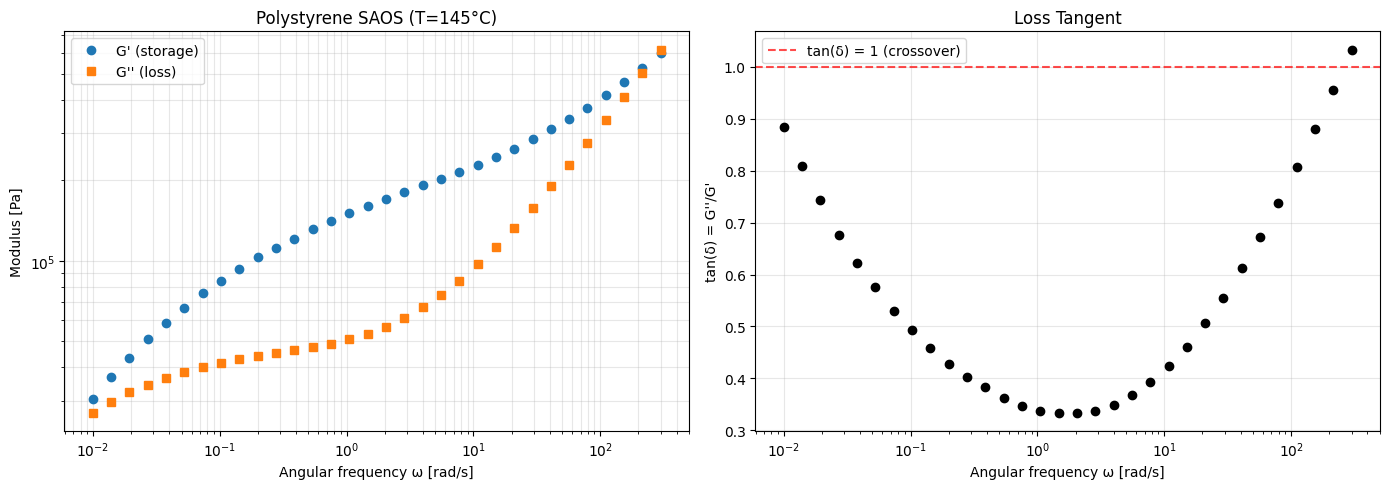

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G', G'' vs omega
ax1.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' (storage)")
ax1.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' (loss)")
ax1.set_xlabel("Angular frequency ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("Polystyrene SAOS (T=145°C)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# tan(δ) = G''/G'
tan_delta = G_double_prime / G_prime
ax2.semilogx(omega, tan_delta, "ko", markersize=6)
ax2.axhline(1.0, color="red", linestyle="--", alpha=0.7, label="tan(δ) = 1 (crossover)")
ax2.set_xlabel("Angular frequency ω [rad/s]")
ax2.set_ylabel("tan(δ) = G''/G'")
ax2.set_title("Loss Tangent")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

In [5]:
# Estimate crossover frequency
# Find where G' ≈ G''
diff = np.abs(G_prime - G_double_prime)
crossover_idx = np.argmin(diff)
omega_c = omega[crossover_idx]
lambda_est = 1.0 / omega_c

print(f"Estimated crossover: ω_c ≈ {omega_c:.3f} rad/s")
print(f"Estimated relaxation time: λ ≈ 1/ω_c = {lambda_est:.3f} s")

Estimated crossover: ω_c ≈ 0.010 rad/s
Estimated relaxation time: λ ≈ 1/ω_c = 100.000 s


## 4. Single-Mode NLSQ Fitting

We first fit a single-mode Giesekus model. Since SAOS is α-independent, we expect the α parameter to be poorly constrained.

In [6]:
# Prepare complex modulus data
# For oscillation test_mode, we need G* = G' + iG''
G_star = np.column_stack([G_prime, G_double_prime])

# Create and fit single-mode Giesekus
model = GiesekusSingleMode()

t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
lambda_1 = model.parameters.get_value("lambda_1")
G_0 = eta_p / lambda_1
omega_c_fit = 1.0 / lambda_1

print(f"\nDerived quantities:")
print(f"  G₀ = η_p/λ = {G_0:.2f} Pa")
print(f"  ω_c = 1/λ = {omega_c_fit:.4f} rad/s")

NLSQ fit time: 0.55 s

Fitted parameters:
  eta_p      = 1e+06
  lambda_1   = 4.923
  alpha      = 0.3
  eta_s      = 1.048

Derived quantities:
  G₀ = η_p/λ = 203139.79 Pa
  ω_c = 1/λ = 0.2031 rad/s


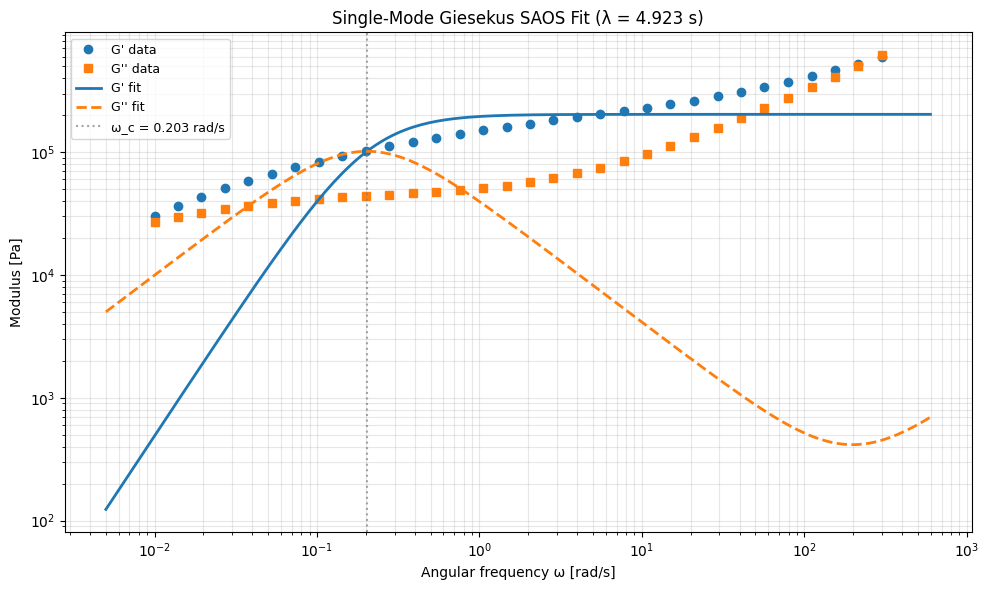

In [7]:
# Plot fit with data
omega_fine = np.logspace(
    np.log10(omega.min()) - 0.3,
    np.log10(omega.max()) + 0.3,
    200,
)

# Predict SAOS moduli
G_star_pred = model.predict(omega_fine, test_mode="oscillation")
G_prime_pred = np.array(G_star_pred)[:, 0]
G_double_prime_pred = np.array(G_star_pred)[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))

# Data
ax.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' data")

# Fit
ax.loglog(omega_fine, G_prime_pred, "-", lw=2, color="C0", label="G' fit")
ax.loglog(omega_fine, G_double_prime_pred, "--", lw=2, color="C1", label="G'' fit")

# Crossover marker
ax.axvline(omega_c_fit, color="gray", linestyle=":", alpha=0.7, 
           label=f"ω_c = {omega_c_fit:.3f} rad/s")

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title(f"Single-Mode Giesekus SAOS Fit (λ = {lambda_1:.3f} s)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

We use NLSQ warm-start for efficient NUTS sampling. Note that α will have a wide posterior since SAOS cannot constrain it.

In [8]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    omega,
    G_star,
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  eta_p: 1e+06
  lambda_1: 4.923
  alpha: 0.3
  eta_s: 1.048


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<06:17,  1.85it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   8%|▊         | 55/700 [00:00<00:05, 114.19it/s, 127 steps of size 1.93e-02. acc. prob=0.94]

warmup:  19%|█▉        | 132/700 [00:00<00:02, 264.62it/s, 63 steps of size 3.09e-02. acc. prob=0.96]

warmup:  26%|██▋       | 185/700 [00:00<00:01, 299.94it/s, 255 steps of size 3.73e-02. acc. prob=0.96]

sample:  33%|███▎      | 232/700 [00:00<00:01, 339.68it/s, 127 steps of size 2.86e-02. acc. prob=0.99]

sample:  40%|███▉      | 279/700 [00:01<00:01, 335.72it/s, 255 steps of size 2.86e-02. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [00:01<00:00, 387.92it/s, 127 steps of size 2.86e-02. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [00:01<00:00, 416.12it/s, 127 steps of size 2.86e-02. acc. prob=0.99]

sample:  62%|██████▏   | 434/700 [00:01<00:00, 435.38it/s, 255 steps of size 2.86e-02. acc. prob=0.99]

sample:  69%|██████▉   | 483/700 [00:01<00:00, 448.67it/s, 159 steps of size 2.86e-02. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [00:01<00:00, 444.15it/s, 255 steps of size 2.86e-02. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [00:01<00:00, 470.96it/s, 23 steps of size 2.86e-02. acc. prob=0.99] 

sample:  91%|█████████ | 634/700 [00:01<00:00, 440.27it/s, 255 steps of size 2.86e-02. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [00:01<00:00, 442.42it/s, 31 steps of size 2.86e-02. acc. prob=0.99] 

sample: 100%|██████████| 700/700 [00:02<00:00, 345.90it/s, 255 steps of size 2.86e-02. acc. prob=0.99]


Bayesian inference time: 6.6 s


In [9]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    status = "PASS" if (r_hat < 1.05 and ess > 100) else "CHECK"
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.0000       500      PASS
    lambda_1    1.0000       500      PASS
       alpha    1.0000       500      PASS
       eta_s    1.0000       500      PASS

Divergences: 1


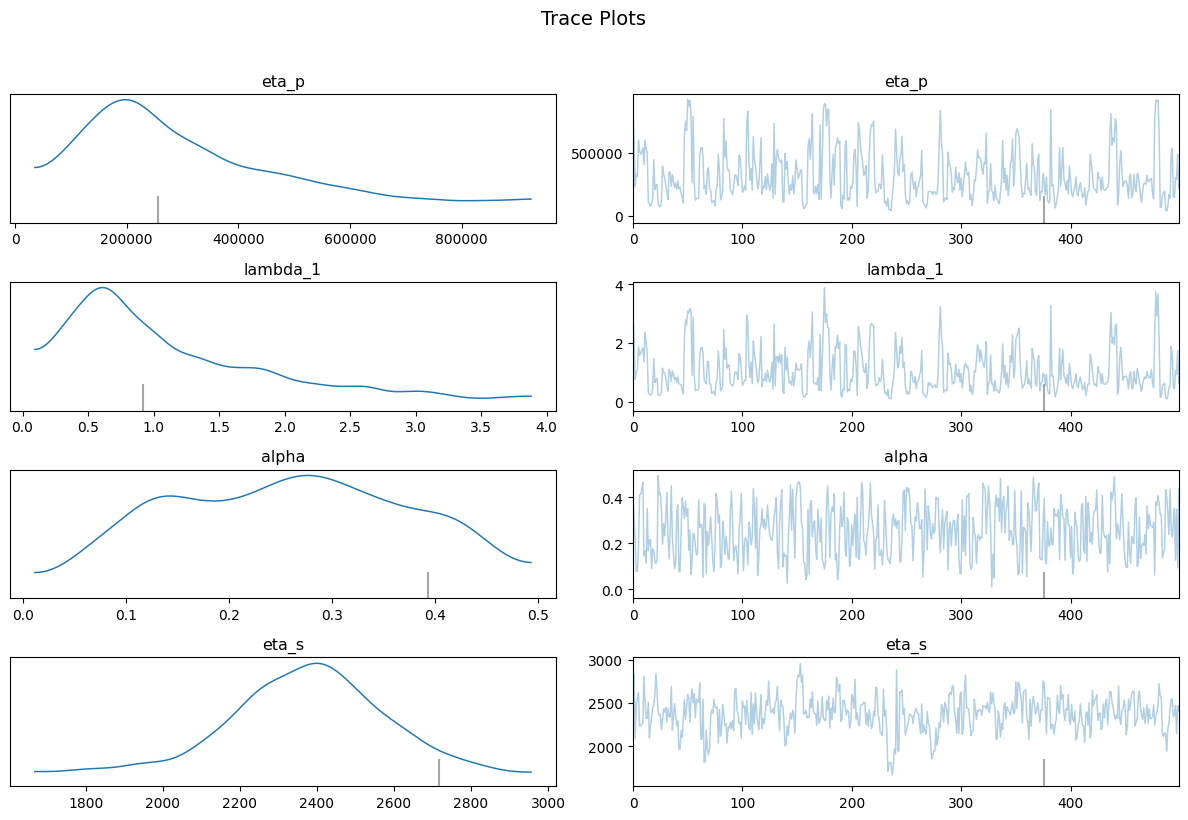

In [10]:
# ArviZ plots
idata = result.to_inference_data()

# Trace plots
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

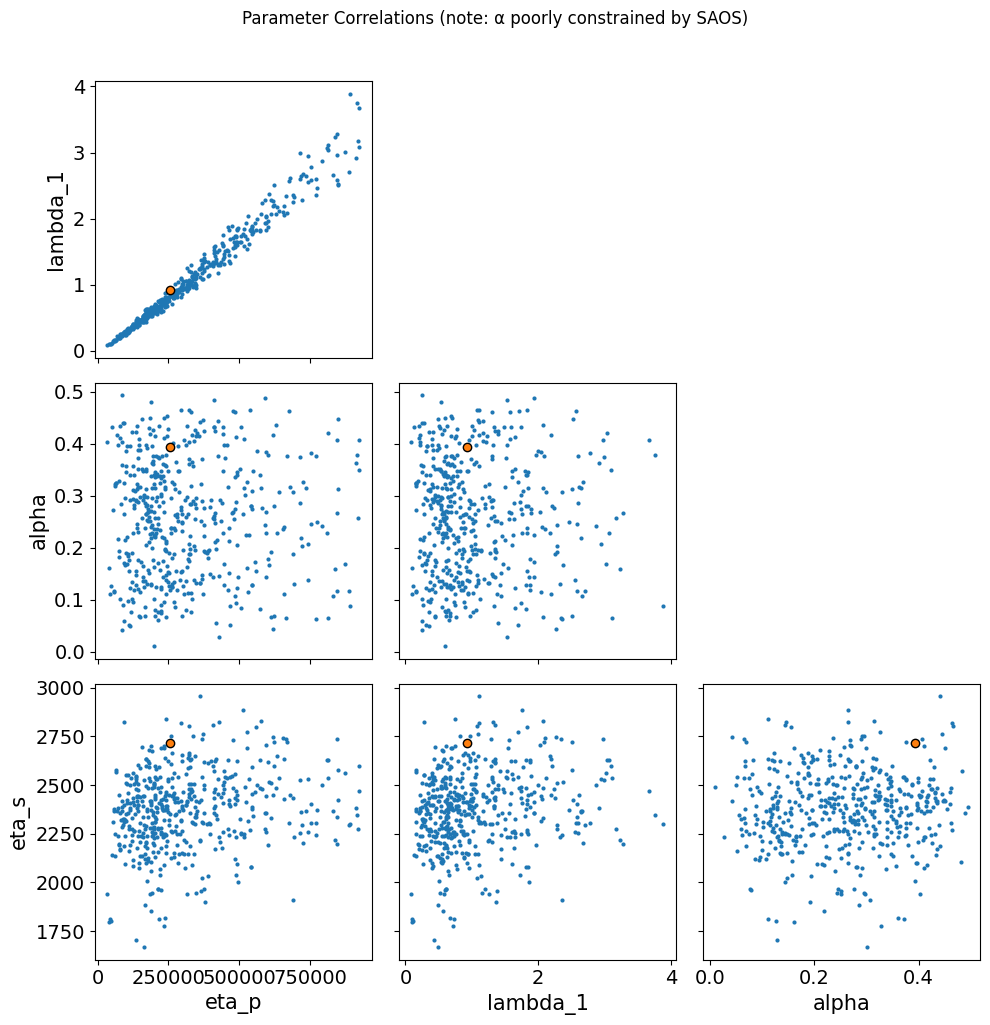

In [11]:
# Pair plot - note the wide α posterior
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations (note: α poorly constrained by SAOS)", fontsize=12, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

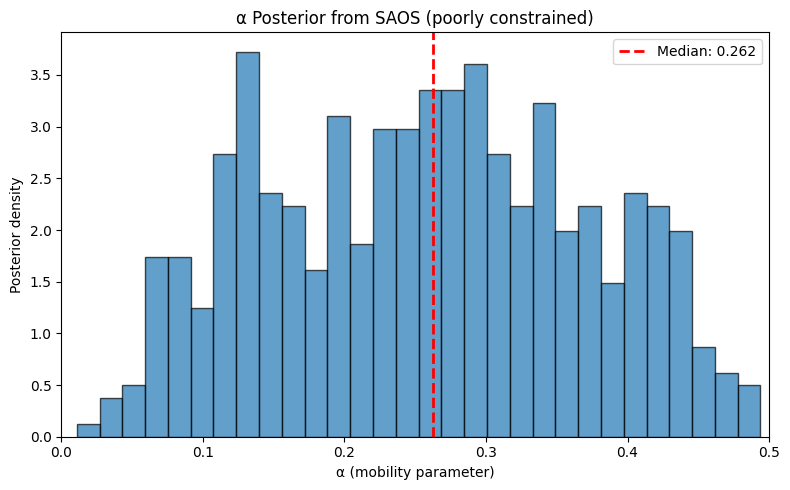

α posterior: mean=0.258, std=0.111
95% CI: [0.066, 0.450]

Note: Wide posterior confirms α is NOT identifiable from SAOS alone!
Use flow curve (NB01) or normal stresses (NB04) to constrain α.


In [12]:
# α posterior - demonstrating that SAOS cannot constrain α
posterior = result.posterior_samples
alpha_samples = np.array(posterior["alpha"])

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(alpha_samples, bins=30, density=True, alpha=0.7, color="C0", edgecolor="black")
ax.axvline(np.median(alpha_samples), color="red", linestyle="--", lw=2, label=f"Median: {np.median(alpha_samples):.3f}")
ax.set_xlabel("α (mobility parameter)")
ax.set_ylabel("Posterior density")
ax.set_title("α Posterior from SAOS (poorly constrained)")
ax.legend()
ax.set_xlim(0, 0.5)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"α posterior: mean={np.mean(alpha_samples):.3f}, std={np.std(alpha_samples):.3f}")
print(f"95% CI: [{np.percentile(alpha_samples, 2.5):.3f}, {np.percentile(alpha_samples, 97.5):.3f}]")
print(f"\nNote: Wide posterior confirms α is NOT identifiable from SAOS alone!")
print(f"Use flow curve (NB01) or normal stresses (NB04) to constrain α.")

## 6. Multi-Mode Fitting

For polymer melts with broad relaxation spectra, a single Maxwell mode is insufficient. Let's fit a 3-mode Giesekus model.

In [13]:
# Helper function to compute fit quality metrics
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Multi-mode Giesekus (3 modes)
model_multi = GiesekusMultiMode(n_modes=3)

t0 = time.time()
model_multi.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_multi = time.time() - t0

# Compute fit quality for both models
G_star_single_pred = model.predict(omega, test_mode="oscillation")
G_star_multi_pred = model_multi.predict(omega, test_mode="oscillation")

metrics_single = compute_fit_quality(G_star, G_star_single_pred)
metrics_multi = compute_fit_quality(G_star, G_star_multi_pred)

print(f"Multi-mode NLSQ fit time: {t_multi:.2f} s")
print(f"\nSingle-mode R²: {metrics_single['R2']:.6f}")
print(f"Multi-mode R²:  {metrics_multi['R2']:.6f}")

Multi-mode NLSQ fit time: 0.65 s

Single-mode R²: -0.138375
Multi-mode R²:  0.845573


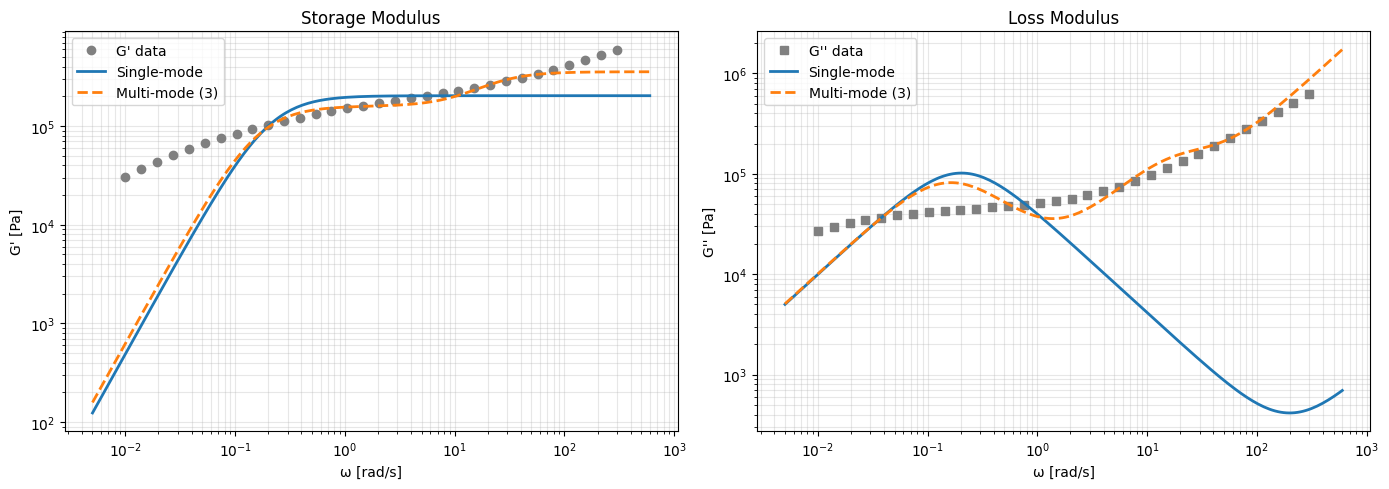

In [14]:
# Compare single vs multi-mode fits
G_star_multi = model_multi.predict(omega_fine, test_mode="oscillation")
G_prime_multi = np.array(G_star_multi)[:, 0]
G_double_prime_multi = np.array(G_star_multi)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G' comparison
ax1.loglog(omega, G_prime, "o", markersize=6, color="gray", label="G' data")
ax1.loglog(omega_fine, G_prime_pred, "-", lw=2, color="C0", label="Single-mode")
ax1.loglog(omega_fine, G_prime_multi, "--", lw=2, color="C1", label="Multi-mode (3)")
ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' [Pa]")
ax1.set_title("Storage Modulus")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# G'' comparison
ax2.loglog(omega, G_double_prime, "s", markersize=6, color="gray", label="G'' data")
ax2.loglog(omega_fine, G_double_prime_pred, "-", lw=2, color="C0", label="Single-mode")
ax2.loglog(omega_fine, G_double_prime_multi, "--", lw=2, color="C1", label="Multi-mode (3)")
ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title("Loss Modulus")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Cole-Cole Representation

The Cole-Cole plot (G'' vs G') provides a visual representation of the relaxation spectrum. A single Maxwell mode gives a semicircle.

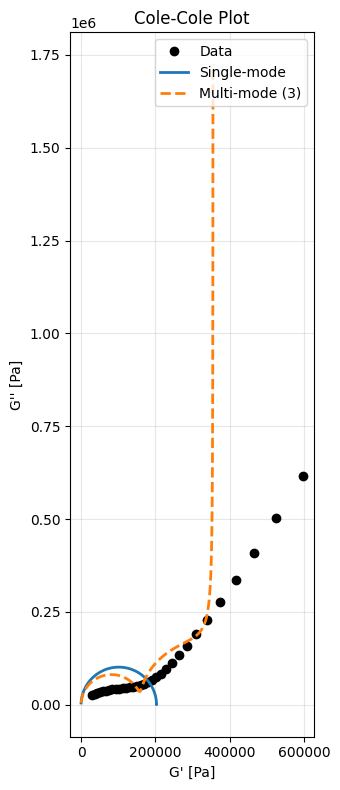

In [15]:
# Cole-Cole plot
fig, ax = plt.subplots(figsize=(8, 8))

# Data
ax.plot(G_prime, G_double_prime, "ko", markersize=6, label="Data")

# Single-mode fit
ax.plot(G_prime_pred, G_double_prime_pred, "-", lw=2, color="C0", label="Single-mode")

# Multi-mode fit
ax.plot(G_prime_multi, G_double_prime_multi, "--", lw=2, color="C1", label="Multi-mode (3)")

ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [16]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "saos")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in param_names
}
with open(os.path.join(output_dir, "nlsq_params_saos.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_saos.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/saos/


## Key Takeaways

1. **SAOS is α-independent** in the linear regime. Giesekus reduces to Maxwell for small amplitudes.

2. **Crossover frequency** ω_c = 1/λ directly gives the relaxation time. This is a robust estimator.

3. **α cannot be determined from SAOS**. The posterior on α is wide because SAOS provides no information about the nonlinear τ·τ term.

4. **Multi-mode fitting** improves agreement for broad relaxation spectra but increases parameter count.

5. **Cole-Cole plots** visualize the relaxation spectrum. Single Maxwell gives a semicircle; deviations indicate multiple modes.

### To Constrain α, Use:

- **Flow curve** (NB 01): α controls shear-thinning onset
- **Normal stresses** (NB 04): N₂/N₁ = -α/2 is a direct measurement
- **LAOS** (NB 07): Nonlinear harmonics depend on α

### Next Steps

- **NB 03**: Startup shear (stress overshoot)
- **NB 04**: Normal stresses (direct α measurement)
- **NB 05**: Creep
- **NB 06**: Stress relaxation
- **NB 07**: LAOS